In [1]:
from PIL import ImageFile, Image
ImageFile.LOAD_TRUNCATED_IMAGES = True
import os
import torch
from glob import glob
import ast
from tqdm import tqdm
import pandas as pd
import numpy as np
from transformers import AutoTokenizer, HfArgumentParser
from torch.utils.data import DataLoader
from utils.utils import seed_everything
from typing import Optional
from dataclasses import dataclass, field
from model.my_model import PPathVLM
from datasets import load_dataset, concatenate_datasets, load_from_disk
from utils.data_collator import MyDataCollatorForPPathVLMTest

from utils.eval_utils import calculate_f1score, compute_bleu_scores

In [2]:
dataset_name_list = ["CNX-PathLLM/Pathcap", "CNX-PathLLM/PubMedPath", "CNX-PathLLM/TwitterPath", "CNX-PathLLM/CleanedTextData"]
split_text = "train"
data_cache_dir = "/home/z/zeyugao/.cache"

clip_name = 'conch'
llm_name = 'meta-llama/Meta-Llama-3-8B-Instruct'

device = 'cuda'

def formatting_func_itp(examples):
    answer = examples["txt"]
    text = f"<DES>"
    examples["text"] = text
    examples["answer"] = answer
    return examples

def formatting_func_ytb(examples):
    text = examples['conversations'].replace("<image>\n", "").replace("<image>", "")
    question = ast.literal_eval(text[1:-1].split('\n')[0])['value'].replace("\n", "")
    answer = ast.literal_eval(text[1:-1].split('\n')[1])['value'].replace("\n", "")
    text = f"<DES>"
    examples["text"] = text
    examples["answer"] = answer
    return examples

In [3]:
seed = 2024
seed_everything(seed)

# set up tokenizer
tokenizer = AutoTokenizer.from_pretrained(llm_name)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"
tokenizer.truncation_side = 'left'

new_tokens = ['<Question>',  '<Answer>', '<DES>', '<Image>']
num_added_toks = tokenizer.add_tokens(new_tokens)
new_tokens_ids = tokenizer.convert_tokens_to_ids(new_tokens)
print("new_tokens_ids: ", new_tokens_ids)

/gpfs/home/z/zeyugao/pyvenv/pathllmGZY/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


new_tokens_ids:  [128256, 128257, 128258, 128259]


In [4]:
ckpt_path = '/home/z/zeyugao/PathLLM/output/Conch_Llama3_PatchInstruct_IT_nytb_des/ckpt_2000.bin'

model = PPathVLM(llm_requires_grad = False, 
                clip_name = clip_name, 
                load_in_8bit = False, 
                load_in_4bit = False, 
                llm_name = llm_name, 
                trust_remote_code = True, 
                token = None, 
                tokenizer = tokenizer,
                image_token_id = new_tokens_ids[-1],
                data_cache_dir = data_cache_dir)

model.load_state_dict(torch.load(ckpt_path, map_location=device))
model.to(device)

vision_encoder loading ...
llm loading ...


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

PPathVLM(
  (vision_encoder): CoCa(
    (text): TextTransformer(
      (token_embedding): Embedding(32007, 768)
      (transformer): Transformer(
        (resblocks): ModuleList(
          (0-11): 12 x ResidualAttentionBlock(
            (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (attn): MultiheadAttention(
              (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
            )
            (ls_1): Identity()
            (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (mlp): Sequential(
              (c_fc): Linear(in_features=768, out_features=3072, bias=True)
              (gelu): GELU(approximate='none')
              (c_proj): Linear(in_features=3072, out_features=768, bias=True)
            )
            (ls_2): Identity()
          )
        )
      )
      (ln_final): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    )
    (visual): VisualModel(
      (trunk): VisionTran

In [6]:
data_collator = MyDataCollatorForPPathVLMTest(tokenizer=tokenizer, image_processor=model.image_processor)

image_paths = glob('/home/z/zeyugao/PathLLM/test_images/*.jpeg')

patch_list = []
num_list = []
text_list = []

for image_path in image_paths:
    image = Image.open(image_path)
    image = data_collator._resize_image(image)
    patches = data_collator._crop_image(image) # [448x448]
    patches = [model.image_processor(patch) for patch in patches]
    num_list.append(len(patches))
    patch_list += patches
    text_list.append(f"<DES>")

patch_list = torch.stack(patch_list) # [448x448]
    
input_dic = tokenizer(text_list, return_tensors="pt")
input_dic["image"] = patch_list
input_dic["patch_num"] = num_list

In [8]:
patch_list.shape

torch.Size([10, 3, 448, 448])

In [9]:
res = model.generate(input_ids=input_dic["input_ids"].to(device),
                     attention_mask=input_dic["attention_mask"].to(device),
                     patch_num=input_dic["patch_num"],
                     image=input_dic["image"].to(device))

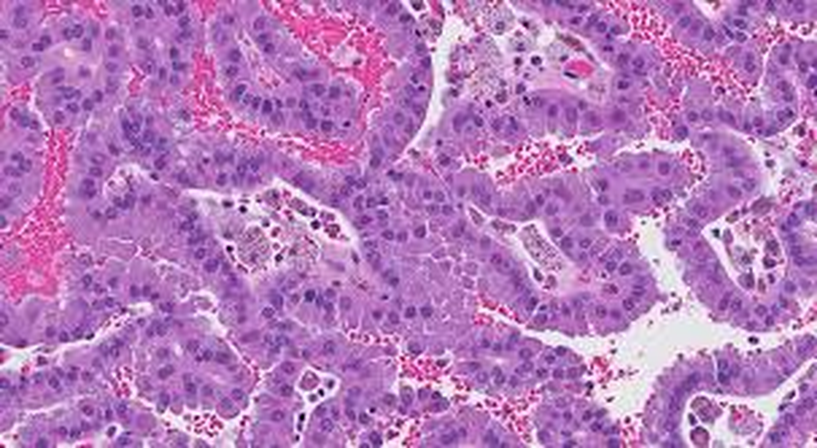

In [24]:
image

In [13]:
for i in range(len(res)):
        print("Description for {}: {} \n".format(image_paths[i], res[i]))

Description for /home/z/zeyugao/PathLLM/test_images/test4.jpeg:  Adnexal duct invasion or entrapment (HE, ×40). HE staining with magnification of 10×. The image shows adnexal duct invasion in tumor cells. In the same area of the tissue sample used for immunohistochemical staining, invasive malignant cells were detected within and/or surrounding blood vessels. This corresponds with a ductal carcinoma as described by WHO class IVc. Histopathological findings are consistent with breast cancer and tumor thrombosis 

Description for /home/z/zeyugao/PathLLM/test_images/test1.jpeg:  Microcystic / Reticular Schwannoma. Nerve sheath tumour, benign & beautiful! Often found incidentally at imaging or during histopath examination of adjacent tissues. Microcystic and reticular patterns may overlap. Occasional mites within tumour. No significant mitotic activity or atypia. +S100. -BRCA1/2, CD34, PR, MART-1/Melan-A, GLI- 

Description for /home/z/zeyugao/PathLLM/test_images/test2.jpeg:  Microscopical

In [15]:
from tqdm import tqdm

widths = []
heights = []

# 遍历数据集并检查每个样本
for idx in tqdm(range(len(dataset))):
    example = dataset[idx]
    img = example["image"]
    width, height = img.size
    widths.append(width)
    heights.append(height)

100%|██████████| 480858/480858 [29:22<00:00, 272.79it/s]


In [22]:
import numpy as np
percentiles = np.percentile(widths, [10, 20, 30, 40, 50, 60, 70, 80, 90])
percentiles
percentiles = np.percentile(widths, [10, 20, 30, 40, 50, 60, 70, 80, 90])
percentiles

array([ 273.,  344.,  360.,  369.,  470.,  600.,  680.,  750., 1227.])

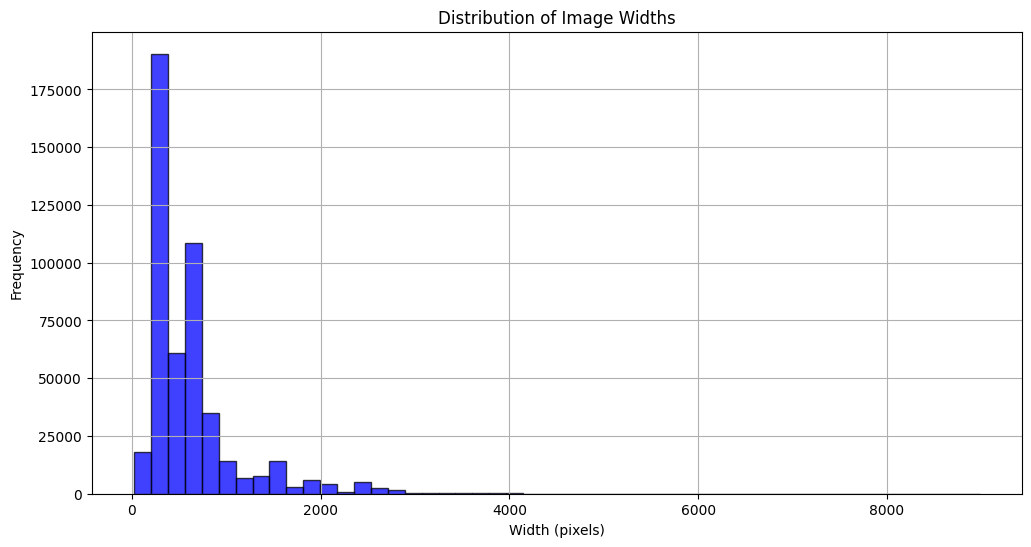

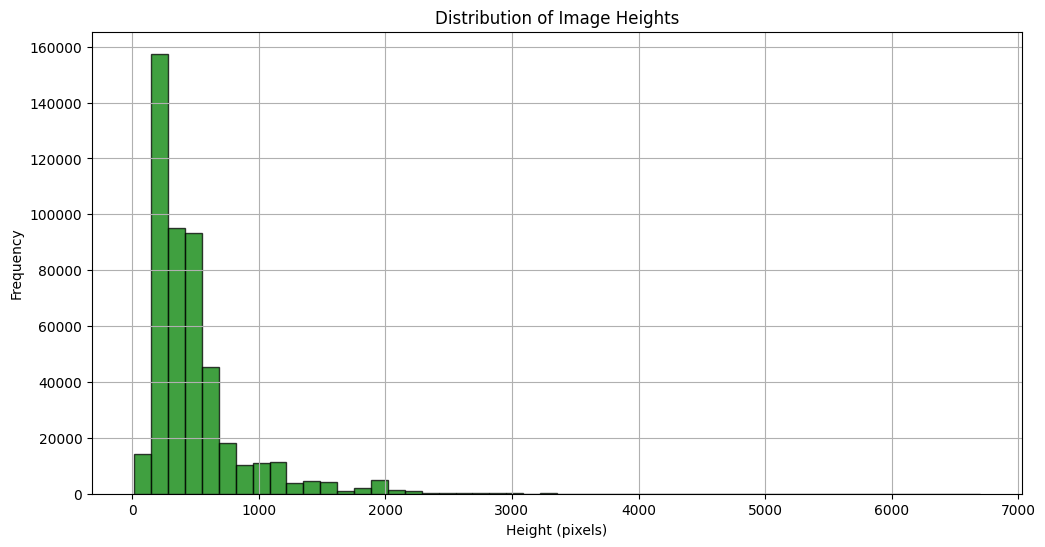

In [17]:
# 生成宽度的直方图
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.hist(widths, bins=50, alpha=0.75, color='blue', edgecolor='black')
plt.title('Distribution of Image Widths')
plt.xlabel('Width (pixels)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# 生成高度的直方图
plt.figure(figsize=(12, 6))
plt.hist(heights, bins=50, alpha=0.75, color='green', edgecolor='black')
plt.title('Distribution of Image Heights')
plt.xlabel('Height (pixels)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [5]:
model = Blip2QformerPatch(clip_name = clip_name,
                            num_query_token=16,
                            cross_attention_freq=2,
                            embed_dim=256,
                            pretrain_name = bert_name,
                            max_txt_len = 256,)

vision_encoder loading ...


In [6]:
data_collator = MyDataCollatorForQFormerPatch(model.image_processor)

In [12]:
sampled_dataset = dataset.select(range(4))

In [14]:
batch = data_collator.torch_call(sampled_dataset)

In [16]:
batch["text"]

['Histopathological features of the lesion (H and E staining) at ×40.',
 'Representative myocardial tissue morphological injuries in the CPR + rhBNP groups. Myocardial injury in the rhBNP group was reduced compared with the placebo group, as characterized by perivascular edema (green arrows), myofibril derangement (black arrows), and neutrophil adhesion (yellow arrows) to the vascular endothelium.',
 'Light microscopy image of the thyroid gland in rats. R2-R4 groups. Hypothyroid tissue with variable form of thyroid follicles. The follicular thyrocytes had hypertrophy and hyperplasia.',
 'Microscopic features of sialolipoma showing a presence of lobules of mature adipose tissue separated by fibrous septae.']